In [1]:
import pypsa
import pandas as pd
import numpy as np

In [2]:
solver = "cbc"

*** 
Check-point 1:

**In this exercise, we will import the copper plate system from Exercise 1 and incorporate a storage power plant into the network. If the system does not activate the storage component, we will explore various solutions to enforce storage behavior within the network.**

> **Remarks:** 
> 
> - While the exercises focus on electricity storage, the same concepts can be applied to create storage solutions for other energy carriers. 
> - In these exercises, we will only work with `StorageUnit` component, meaning energy-to-power ratio for storage plant is fixed. To optimise the storage energy capacity independently from the storage power capacity (e.g. in case of hydrogen or gas storage, etc), you should use a fundamental `Store` component in combination with `Link` component (Have a look at this [PyPSA example](https://pypsa.readthedocs.io/en/latest/examples/replace-generator-storage-units-with-store.html)). We will touch on this implementation on day 2 of the training.

#### Initialize network

In [3]:
# import checkpoint point 3 network from exercise 1
n = pypsa.Network("../results/network_d1_e1-3.nc")

INFO:pypsa.io:Imported network network_d1_e1-3.nc has buses, generators, loads


In [4]:
n.generators

,bus,marginal_cost,p_nom_opt,p_nom_extendable,capital_cost,efficiency,control,type,p_nom,p_nom_mod,...,stand_by_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight
Generator,,,,,,,,,,,,,,,,,,,,,
nuclear_power_plant,electricity,15.403067,-0.00000,True,670995.452213,0.326,PQ,,0.0,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,1.0
gas_power_plant,electricity,48.105263,100.00000,True,103849.929794,0.570,PQ,,0.0,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,1.0
solar_farm,electricity,0.010600,144.93804,True,44324.171529,1.000,PQ,,0.0,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,1.0


In [5]:
n.loads

,bus,p_set,carrier,type,q_set,sign
Load,,,,,,
electricity_load,electricity,100.0,,,0.0,-1.0


#### Increase `electricity_load` load to `200MW` 

In [6]:
# You can modify network's component values directly via component's dataframe, make sure to locate correct index 
load_id = n.loads[n.loads.bus == 'electricity'].index
n.loads.loc[load_id, 'p_set'] = 200

In [7]:
n.loads

,bus,p_set,carrier,type,q_set,sign
Load,,,,,,
electricity_load,electricity,200.0,,,0.0,-1.0


Add a pumped-hydro power plant to the network with a fixed energy-to-power ratio of `8 hours`. The rated capacity of the plant should be endogenously decided by the model. All other techno-economic parameters are provided.

> **Source:** all costs for the example are taken from Danish energy agency technology database for energy storage (https://ens.dk/en/our-services/technology-catalogues/technology-data-energy-storage)

In [8]:
# We need to calculate annualized capital expenditure
def calculate_annualised_capex(capex: float, interest: float, lifetime: int):
    crf = (
        interest * (1 + interest) ** lifetime / ((1 + interest) ** lifetime - 1)
    )  # Capital recovery factor
    return capex * crf

In [9]:
# Pumped-hydro power plant techno-economic parameters are given as:
lifetime = 50
interest = 0.05
CAPEX = 600000 # $/MW
FOM = 12000  # $/MW fixed
VOM = 3.9 # $/MWh variable
fuel_cost = 0 # $/MWhth per unit water consumed
efficiency_store = 0.8 # assuming similar storing and discharging effciencies
efficiency_dispatch = 0.8 # assuming similar storing and discharging effciencies

In [10]:
annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)

n.add(
    class_name="StorageUnit",
    name="pumped_hydro_storage",
    bus="electricity",
    marginal_cost=VOM + fuel_cost,
    capital_cost=annualized_capex + FOM,
    p_nom_extendable=True,
    efficiency_store=0.8,
    efficiency_dispatch=0.8,
    p_max_pu=1,  # Discharging availability
    p_min_pu=-1,  # Charging availability
    max_hours=8,  # energy to power ratio
)

Now try to solve the network

In [11]:
# Solve network using cbc solver
n.optimize(solver_name=solver)

INFO:linopy.model: Solve problem using Cbc solver
INFO:linopy.model:Solver options:
 - pyomo: False
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 82.51it/s]
INFO:linopy.io: Writing time: 0.59s
INFO:linopy.solvers:Welcome to the CBC MILP Solver 
Version: 2.10.10 
Build Date: Apr 19 2023 

command line - cbc -printingOptions all -import /tmp/linopy-problem-f2ow30g6.lp -pyomo False -solve -solu /tmp/linopy-solve-s_ky_cwm.sol (default strategy 1)
Option for printingOptions changed from normal to all
No match for pyomo - ? for list of commands
No match for False - ? for list of commands
Presolve 65334 (-57310) rows, 47818 (-4746) columns and 169722 (-62056) elements
Perturbing problem by 0.001% of 153.25616 - largest nonzero change 0.00025325435 ( 8.2623332%) - largest zero change 0.00025230909
0  Obj 0 Primal inf 1823308.9 (8760)
551  Obj 32249.372 Primal inf 2202396.7 (8800)
1102  Obj 160641.83 Primal inf 2093379.2 (8964)
1653  Obj 272

('ok', 'optimal')

Check if the storage plant is being invested or not?

In [12]:
n.storage_units["p_nom_opt"]

StorageUnit
pumped_hydro_storage    0.0
Name: p_nom_opt, dtype: float64

Check capacities from other technologies

In [13]:
n.generators['p_nom_opt']

Generator
nuclear_power_plant     -0.00000
gas_power_plant        200.00000
solar_farm             289.87608
Name: p_nom_opt, dtype: float64

Ending of check-point 1 - export network

In [14]:
# Export network
n.export_to_netcdf("../results/network_d1_e2-1.nc")

INFO:pypsa.io:Exported network network_d1_e2-1.nc has buses, loads, generators, storage_units


<xarray.Dataset> Size: 841kB
Dimensions:                            (snapshots: 8760, investment_periods: 0,
                                        buses_i: 1, buses_t_p_i: 1,
                                        buses_t_marginal_price_i: 1,
                                        loads_i: 1, loads_t_p_i: 1,
                                        generators_i: 3,
                                        generators_t_p_max_pu_i: 1,
                                        generators_t_p_i: 2,
                                        storage_units_i: 1,
                                        storage_units_t_state_of_charge_i: 1)
Coordinates:
  * snapshots                          (snapshots) int64 70kB 0 1 ... 8758 8759
  * investment_periods                 (investment_periods) int64 0B 
  * buses_i                            (buses_i) object 8B 'electricity'
  * buses_t_p_i                        (buses_t_p_i) object 8B 'electricity'
  * buses_t_marginal_price_i           (buses_t_marginal_price_i) object 8B '...
  * loads_i                            (loads_i) object 8B 'electricity_load'
  * loads_t_p_i                        (loads_t_p_i) object 8B 'electricity_l...
  * generators_i                       (generators_i) object 24B 'nuclear_pow...
  * generators_t_p_max_pu_i            (generators_t_p_max_pu_i) object 8B 's...
  * generators_t_p_i                   (generators_t_p_i) object 16B 'gas_pow...
  * storage_units_i                    (storage_units_i) object 8B 'pumped_hy...
  * storage_units_t_state_of_charge_i  (storage_units_t_state_of_charge_i) object 8B ...
Data variables: (12/27)
    snapshots_snapshot                 (snapshots) datetime64[ns] 70kB 2023-0...
    snapshots_objective                (snapshots) float64 70kB 1.0 1.0 ... 1.0
    snapshots_generators               (snapshots) float64 70kB 1.0 1.0 ... 1.0
    snapshots_stores                   (snapshots) float64 70kB 1.0 1.0 ... 1.0
    investment_periods_objective       (investment_periods) float64 0B 
    investment_periods_years           (investment_periods) float64 0B 
    ...                                 ...
    storage_units_marginal_cost        (storage_units_i) float64 8B 3.9
    storage_units_capital_cost         (storage_units_i) float64 8B 4.487e+04
    storage_units_max_hours            (storage_units_i) float64 8B 8.0
    storage_units_efficiency_store     (storage_units_i) float64 8B 0.8
    storage_units_efficiency_dispatch  (storage_units_i) float64 8B 0.8
    storage_units_t_state_of_charge    (snapshots, storage_units_t_state_of_charge_i) float64 70kB ...
Attributes:
    network__linearized_uc:      0
    network__multi_invest:       0
    network_name:                
    network_objective:           90766881.11261995
    network_objective_constant:  0.0
    network_pypsa_version:       0.28.0
    network_srid:                4326
    crs:                         {"_crs": "GEOGCRS[\"WGS 84\",ENSEMBLE[\"Worl...
    meta:                        {}

*** 
Check-point 2:

**How to force investment into storage?**
#### TASK: Modify the network to make it invest in either of storage options

> **Hint: None of the two storage options are invested because storage is not as cost optimal as continue using solar and gas.** 

Option 1: Making cost of storage options to as lower as the model invest in instead of use other generators

In [15]:
# import checkpoint point 1 network
n = pypsa.Network("../results/network_d1_e2-1.nc")

INFO:pypsa.io:Imported network network_d1_e2-1.nc has buses, generators, loads, storage_units


In [16]:
n.storage_units.loc["pumped_hydro_storage"]

bus                                    electricity
p_nom_extendable                              True
marginal_cost                                  3.9
capital_cost                          44866.041291
max_hours                                      8.0
efficiency_store                               0.8
efficiency_dispatch                            0.8
control                                         PQ
type                                              
p_nom                                          0.0
p_nom_mod                                      0.0
p_nom_min                                      0.0
p_nom_max                                      inf
p_min_pu                                      -1.0
p_max_pu                                       1.0
p_set                                          0.0
q_set                                          0.0
sign                                           1.0
carrier                                           
marginal_cost_quadratic        

In [17]:
# Remove capital costs of storage plants
n.storage_units.loc['pumped_hydro_storage', 'capital_cost'] = 0

In [18]:
# Solve network again
n.optimize(solver_name=solver)

INFO:linopy.model: Solve problem using Cbc solver
INFO:linopy.model:Solver options:
 - pyomo: False
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 81.56it/s]
INFO:linopy.io: Writing time: 0.59s
INFO:linopy.solvers:Welcome to the CBC MILP Solver 
Version: 2.10.10 
Build Date: Apr 19 2023 

command line - cbc -printingOptions all -import /tmp/linopy-problem-4pzkl908.lp -pyomo False -solve -solu /tmp/linopy-solve-gnabmqlb.sol (default strategy 1)
Option for printingOptions changed from normal to all
No match for pyomo - ? for list of commands
No match for False - ? for list of commands
Presolve 39054 (-83590) rows, 47816 (-4748) columns and 117160 (-114618) elements
Perturbing problem by 0.001% of 153.25616 - largest nonzero change 0.00025324249 ( 8.2404539%) - largest zero change 0.00012662698
0  Obj 0 Primal inf 1823330.3 (8760)
420  Obj 7921.3701 Primal inf 2212880.6 (8760)
840  Obj 100350.7 Primal inf 2123138.7 (8760)
1260  Obj 1989

('ok', 'optimal')

Now inspect the invested capacity and dispatch pattern of the system again.

In [19]:
# Inspect capacity of pumped hydro storage
n.storage_units.loc['pumped_hydro_storage', 'p_nom_opt']

729.55254

In [20]:
# Inspect capacity of other plants
n.generators['p_nom_opt']

Generator
nuclear_power_plant      -0.0000
gas_power_plant         200.0000
solar_farm             1109.3042
Name: p_nom_opt, dtype: float64

In [21]:
# Inspect storage interaction with other powerplants to supply loads
load = n.loads_t.p 
pow_gen = n.generators_t.p
storage = n.storage_units_t.p
result = pd.concat([pow_gen, storage, load], axis=1)
result.round().head(24)

,gas_power_plant,nuclear_power_plant,solar_farm,pumped_hydro_storage,electricity_load
snapshot,,,,,
2023-01-01 00:00:00,200.0,0.0,-0.0,0.0,200.0
2023-01-01 01:00:00,200.0,0.0,-0.0,0.0,200.0
2023-01-01 02:00:00,200.0,0.0,-0.0,0.0,200.0
2023-01-01 03:00:00,200.0,0.0,-0.0,0.0,200.0
2023-01-01 04:00:00,200.0,0.0,-0.0,0.0,200.0
2023-01-01 05:00:00,200.0,0.0,-0.0,0.0,200.0
2023-01-01 06:00:00,200.0,0.0,-0.0,0.0,200.0
2023-01-01 07:00:00,178.0,0.0,22.0,0.0,200.0
2023-01-01 08:00:00,-0.0,0.0,296.0,-96.0,200.0


<Axes: xlabel='snapshot'>

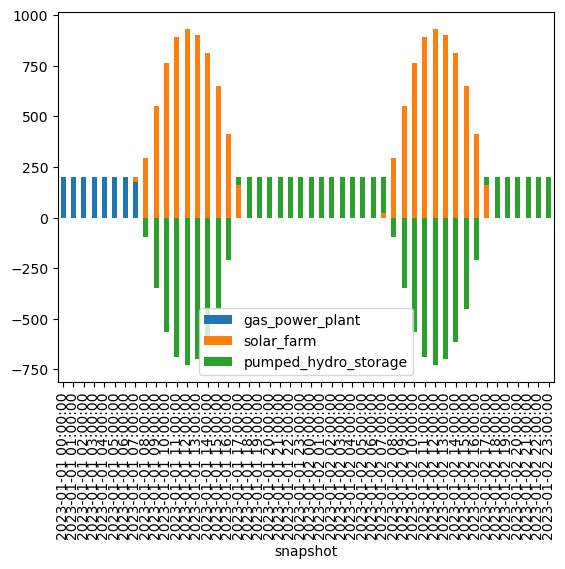

In [22]:
plot = result.loc[:,~result.columns.isin(['electricity_load', 'nuclear_power_plant'])] # drop load and nuclear columns
plot.iloc[:48,:].plot(kind='bar', stacked=True)

Option 2: Having some initial filling for storage

> **Remarks:You can use `state_of_charge_initial` to set initial filling of an storage.**

In [23]:
# import checkpoint point 1 network
n = pypsa.Network("../results/network_d1_e2-1.nc")

INFO:pypsa.io:Imported network network_d1_e2-1.nc has buses, generators, loads, storage_units


In [24]:
# adding inital filling of storage to cover first 8 hours without sun
n.storage_units.loc['pumped_hydro_storage', 'state_of_charge_initial'] = 200*8 # load * 8hours

In [25]:
# Solve network again
n.optimize(solver_name=solver)

INFO:linopy.model: Solve problem using Cbc solver
INFO:linopy.model:Solver options:
 - pyomo: False
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 80.63it/s]
INFO:linopy.io: Writing time: 0.56s
INFO:linopy.solvers:Welcome to the CBC MILP Solver 
Version: 2.10.10 
Build Date: Apr 19 2023 

command line - cbc -printingOptions all -import /tmp/linopy-problem-cgilylt3.lp -pyomo False -solve -solu /tmp/linopy-solve-lrcedfk_.sol (default strategy 1)
Option for printingOptions changed from normal to all
No match for pyomo - ? for list of commands
No match for False - ? for list of commands
Presolve 65335 (-57309) rows, 47819 (-4745) columns and 169724 (-62054) elements
Perturbing problem by 0.001% of 153.25616 - largest nonzero change 0.00025325435 ( 8.2623332%) - largest zero change 0.00025230909
0  Obj 0 Primal inf 1824619 (8761)
551  Obj 7786526 Primal inf 2203778.4 (8792)
1102  Obj 7913364.9 Primal inf 2060673.1 (8953)
1653  Obj 8028563

('ok', 'optimal')

Now inspect the invested capacity and dispatch pattern of the system again.

In [26]:
n.storage_units['p_nom_opt']

StorageUnit
pumped_hydro_storage    534.23659
Name: p_nom_opt, dtype: float64

In [27]:
# Inspect capacity of other plants
n.generators['p_nom_opt']

Generator
nuclear_power_plant      -0.000000
gas_power_plant          37.493115
solar_farm             1002.754100
Name: p_nom_opt, dtype: float64

<Axes: xlabel='snapshot'>

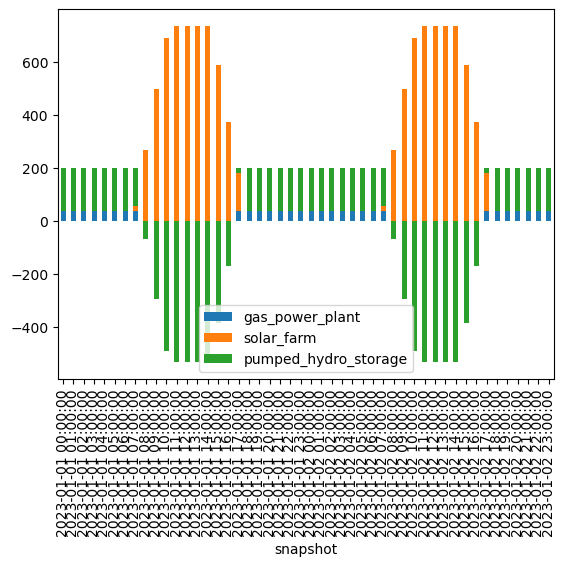

In [28]:
# Inspect storage interaction with other powerplants to supply loads
load = n.loads_t.p 
pow_gen = n.generators_t.p
storage = n.storage_units_t.p
result = pd.concat([pow_gen, storage, load], axis=1)

plot = result.loc[:,~result.columns.isin(['electricity_load', 'nuclear_power_plant'])] # drop load and nuclear columns
plot.iloc[:48,:].plot(kind='bar', stacked=True)